In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
 
import azureml
from azureml.core import Workspace, Run
from azureml.core.model import Model
import os
from azureml.core import Environment
from azureml.core.webservice import Webservice
from azureml.core.model import Model, InferenceConfig

# Display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

ws = Workspace.from_config()

Azure ML SDK Version:  1.0.83


In [2]:
service_name = 'test-deploy'
# Retrieve existing service.
service = Webservice(name=service_name, workspace=ws)


In [3]:
print(service.state)
print(service.get_logs())

Healthy
2020-01-21T02:21:18,735021713+00:00 - rsyslog/run 
2020-01-21T02:21:18,734238109+00:00 - gunicorn/run 
2020-01-21T02:21:18,737002221+00:00 - iot-server/run 
2020-01-21T02:21:18,833335538+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2020-01-21T02:21:21,033380557+00:00 - iot-server/finish 1 0
2020-01-21T02:21:21,133332690+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.9.0
Listening at: http://127.0.0.1:31311 (12)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 43
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
/opt/miniconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install jobl

In [4]:
print(service.scoring_uri)

http://8cc3605f-4e8e-44b0-a6a5-bf1ec7ce2765.eastus.azurecontainer.io/score


### Test the deployed service

Earlier, you scored all the test data with the local version of the model. Now you can test the deployed model with a random sample of 30 images from the test data.

The following code goes through these steps:

1. Send the data as a JSON array to the web service hosted in Container Instances.

2. Use the SDK's run API to invoke the service. You can also make raw calls by using any HTTP tool such as curl.

3. Print the returned predictions and plot them along with the input images. Red font and inverse image, white on black, is used to highlight the misclassified samples.

Because the model accuracy is high, you might have to run the following code a few times before you can see a misclassified 

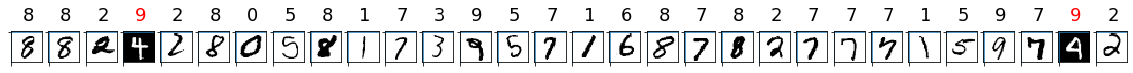

In [6]:
import os
import json
import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays

def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array

def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

data_folder = os.path.join(os.getcwd(), 'data')

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster

X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize=(20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send a raw HTTP request to test the web service:


In [7]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type': 'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://8cc3605f-4e8e-44b0-a6a5-bf1ec7ce2765.eastus.azurecontainer.io/score
label: 8
prediction: [8]


In [8]:
service.delete()